In [ ]:
%cd '/content/drive/My Drive/Self Case Study-2'

/content/drive/My Drive/Self Case Study-2


#Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore') 
from os import listdir
from os.path import isfile, join
import argparse
import cv2
import numpy as np
import sys
import os
import shutil
import random 
import math
import pandas as pd
import ast
from tqdm import tqdm
from operator import itemgetter
import json
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

# Preparing Dataset


## Train, Test and JSON to CSV

Select image that contain alteast one tank object then extracting Bounding Boxes from Json file and converting into CSV file with format [image path, class labe, class name, bounding box]. boundig box will in list format [xmin, ymin, xmax, ymax].

In [ ]:
def conv_bbox(box_dict):

    """
    input: box_dict-> bounding box with 4 corner points in dictionary
    Function: Obtaining top-left and bottom-right points
    output: tuple(ymin, xmin, ymax, xmax)
    """
    
    xs = np.array(list(set([i['x'] for i in box_dict])))
    ys = np.array(list(set([i['y'] for i in box_dict])))
    
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    
    return y_min, x_min, y_max, x_max

In [ ]:
source = 'data/image_patches'
annotations = []
class_map = {'Tank': 0, 'Tank Cluster': 1, 'Floating Head Tank': 2}
json_labels = json.load(open('data/labels.json')) #Loading labels.json file

for i in tqdm(range(len(json_labels[:]))):
    file = json_labels[i]['file_name']
    if(json_labels[i]['label']!='Skip'):  
        for label in json_labels[i]['label'].keys():
            for box in json_labels[i]['label'][label]:
                y_min, x_min, y_max, x_max = conv_bbox(box['geometry'])
                annotations.append((os.path.join(source,file),
                                    class_map[label], 
                                    label, 
                                    [x_min, y_min, x_max, y_max]
                                    ))

annotations = pd.DataFrame(
    annotations, 
    columns=['image_name', 'class', 'class_name', 'bbox']
)
annotations.to_csv('data/annotations.csv', index=False) #Saving
print('Number of Annotated Tanks: ', len(annotations))
annotations.head(10)

100%|██████████| 10000/10000 [00:00<00:00, 57953.43it/s]


Number of Annotated Tanks:  9051


,image_name,class,class_name,bbox
0,data/image_patches/01_0_4.jpg,0,Tank,"[438, 254, 455, 271]"
1,data/image_patches/01_0_4.jpg,0,Tank,"[388, 259, 408, 279]"
2,data/image_patches/01_2_1.jpg,0,Tank,"[103, 310, 133, 334]"
3,data/image_patches/01_2_1.jpg,0,Tank,"[265, 315, 289, 338]"
4,data/image_patches/01_2_1.jpg,0,Tank,"[269, 344, 284, 359]"
5,data/image_patches/01_2_1.jpg,0,Tank,"[266, 367, 284, 385]"
6,data/image_patches/01_2_2.jpg,0,Tank,"[24, 299, 82, 352]"
7,data/image_patches/01_2_2.jpg,0,Tank,"[151, 303, 209, 355]"
8,data/image_patches/01_2_2.jpg,0,Tank,"[278, 304, 337, 358]"
9,data/image_patches/01_2_3.jpg,0,Tank,"[52, 308, 111, 364]"


## Grouping

As you can see in above CSV file, each row containing a single bounding boxes and each image may have more than one bounding boxes, thus we are grouping all bounding boxes for single image in a list

In [ ]:
df = annotations.groupby('image_name')['bbox'].apply(list).reset_index(name='bboxes')
df['classes'] = annotations.groupby('image_name')['class_name'].apply(list).reset_index(drop=True)
print('Number of Images with Aleast On Object: ', len(df))
df.head(10)

Number of Images with Aleast On Object:  1828


,image_name,bboxes,classes
0,data/image_patches/01_0_4.jpg,"[[438, 254, 455, 271], [388, 259, 408, 279]]","[Tank, Tank]"
1,data/image_patches/01_2_1.jpg,"[[103, 310, 133, 334], [265, 315, 289, 338], [...","[Tank, Tank, Tank, Tank]"
2,data/image_patches/01_2_2.jpg,"[[24, 299, 82, 352], [151, 303, 209, 355], [27...","[Tank, Tank, Tank]"
3,data/image_patches/01_2_3.jpg,"[[52, 308, 111, 364]]",[Tank]
4,data/image_patches/01_2_4.jpg,"[[153, 416, 214, 474]]",[Tank]
5,data/image_patches/01_2_6.jpg,"[[483, 284, 511, 316], [482, 325, 512, 356]]","[Tank, Tank]"
6,data/image_patches/01_2_7.jpg,"[[8, 284, 41, 316], [8, 324, 41, 356], [55, 28...","[Tank, Tank, Tank, Tank, Tank, Tank, Tank, Tan..."
7,data/image_patches/01_2_8.jpg,"[[42, 218, 146, 320], [42, 444, 146, 511], [45...","[Tank, Tank, Tank, Floating Head Tank]"
8,data/image_patches/01_2_9.jpg,"[[1, 412, 42, 473]]",[Tank]
9,data/image_patches/01_3_0.jpg,"[[214, 321, 233, 338], [173, 200, 196, 219], [...","[Tank, Tank, Tank, Tank, Floating Head Tank, T..."


## Splitting into Train, Test Set

Among 1828 image Keeping 10% of that for the test and 90% for train

In [ ]:
# train and Test Split
df_train, df_test= model_selection.train_test_split(
    df, 
    test_size=0.1, 
    random_state=42, 
    shuffle=True,
)

df_train.shape, df_test.shape

((1645, 3), (183, 3))

# Data Augmentation
As we know that Object detection needs lots of data but we have 1645 images for the training which is very less. To increase the data we are bound to do Data Augmentation. Here new images are generated by flipping and Rotating original Images. All the codes are extracted from [this](https://blog.paperspace.com/data-augmentation-for-bounding-boxes/) GitHub repository, all credits go to him/her. We are generating 7 new images from a single original images
1. Horizontal Fliping
2. Rotating 90 degree
3. Rotating 180 degree
4. Rotating 270 degree
5. Horizontal Flipping and 90-degree Rotating
6. Horizontal Flipping and 180-degree Rotating
7. Horizontal Flipping and 270-degree Rotating

In the below cell you can see an example




## Function and Classes for Stated Augmentation

In [ ]:
def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    Parameters
    ----------
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    Returns
    -------
    numpy.ndarray
        numpy image with bounding boxes drawn on it
    """
    im = im.copy()
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    Parameters
    ----------
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    Returns
    -------
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)

    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    mask = (delta_area < (1 - alpha)).astype(int)
    bbox = bbox[mask == 1,:]

    return bbox

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def rotate_im(image, angle):
    """Rotate the image
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    Parameters
    ----------
    image : numpy.ndarray
        numpy image
    angle : float
        angle by which the image is to be rotated
    Returns
    -------
    numpy.ndarray
        Rotated Image
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):
    
    """Get corners of bounding boxes
    Parameters
    ----------
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    returns
    -------
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    Parameters
    ----------
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    Parameters
    ----------
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    Returns 
    -------
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`  
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final


class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
            img_center = np.array(img.shape[:2])[::-1]/2
            img_center = np.hstack((img_center, img_center))
            if random.random() < self.p:
                img = img[:, ::-1, :]
                bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

                box_w = abs(bboxes[:, 0] - bboxes[:, 2])

                bboxes[:, 0] -= box_w
                bboxes[:, 2] += box_w

            return img, bboxes

class Rotate(object):
    """Rotates an image    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    Parameters
    ----------
    angle: float
        The angle by which the image is to be rotated 
    Returns
    -------
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box 
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image. 
        """
        
        angle = self.angle
        # print(self.angle)
        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
        corners = get_corners(bboxes)
        corners = np.hstack((corners, bboxes[:,4:]))
        img = rotate_im(img, angle)
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        new_bbox = get_enclosing_box(corners)
        scale_factor_x = img.shape[1] / w
        scale_factor_y = img.shape[0] / h
        img = cv2.resize(img, (w,h))
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        bboxes  = new_bbox
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)

        return img, bboxes

## Augmenting Data and Storing in CSV File

100%|██████████| 1645/1645 [1:42:10<00:00,  3.73s/it]


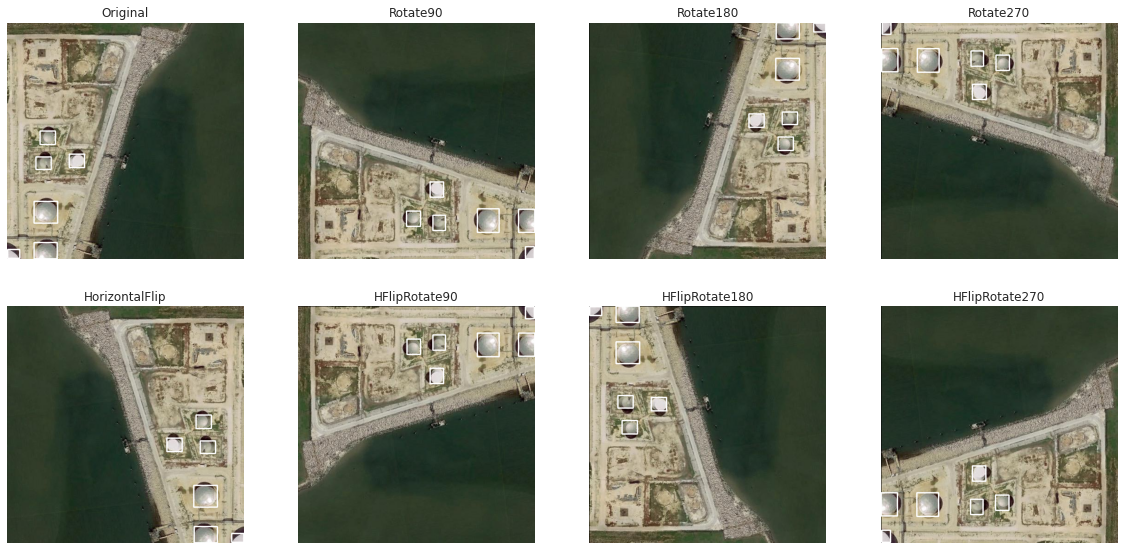


Number of augmented Images:  11515


,image_name,bboxes,classes
0,data/Rotate90/02_1_8.jpg,"[[300, 481, 323, 507], [15, 482, 91, 511], [2,...","[Tank, Tank, Tank]"
1,data/Rotate180/02_1_8.jpg,"[[481, 189, 507, 212], [482, 421, 511, 497], [...","[Tank, Tank, Tank]"
2,data/Rotate270/02_1_8.jpg,"[[189, 5, 212, 31], [421, 1, 497, 30], [464, 5...","[Tank, Tank, Tank]"
3,data/HorizontalFlip/02_1_8.jpg,"[[481, 300, 507, 323], [482, 15, 511, 91], [40...","[Tank, Tank, Tank]"
4,data/HFlipRotate90/02_1_8.jpg,"[[300, 5, 323, 31], [15, 1, 91, 30], [2, 58, 4...","[Tank, Tank, Tank]"
5,data/HFlipRotate180/02_1_8.jpg,"[[5, 189, 31, 212], [1, 421, 30, 497], [58, 46...","[Tank, Tank, Tank]"
6,data/HFlipRotate270/02_1_8.jpg,"[[189, 481, 212, 507], [421, 482, 497, 511], [...","[Tank, Tank, Tank]"
7,data/Rotate90/88_6_7.jpg,"[[60, 37, 127, 106]]",[Floating Head Tank]
8,data/Rotate180/88_6_7.jpg,"[[37, 385, 106, 452]]",[Floating Head Tank]
9,data/Rotate270/88_6_7.jpg,"[[385, 406, 452, 475]]",[Floating Head Tank]


In [ ]:
augment_data = []
class_names = {0:'Tank', 1:'Tank Cluster', 2:'Floating Head Tank'}

augmentation_list = ["Rotate90", "Rotate180","Rotate270","HorizontalFlip",
                     "HFlipRotate90", "HFlipRotate180", "HFlipRotate270"]

sns.set({'figure.figsize':(20,20)})

for folder in augmentation_list:
    if not os.path.isdir(os.path.join('data', folder)):
        os.mkdir(os.path.join('data', folder))

df_train = df_train.reset_index(drop=True)
for _, row in tqdm(df_train[:].iterrows(), total=len(df_train)):
    bboxes = []
    for bbox, Class in zip(row['bboxes'], row['classes']):
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        label = class_map[Class]
        bboxes.append([xmin, ymin, xmax, ymax, label])

    bboxes = np.array(bboxes, dtype=float)
    # opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
    img = cv2.imread(row['image_name'])[:,:,::-1]
    if(_ == 2):
        plt.subplot(4,4, 1)
        plotted_img = draw_rect(img, bboxes)
        plt.imshow(plotted_img)
        plt.title("Original")
        plt.axis("off")
        plt.grid(False)

    for index,augmentation in enumerate(augmentation_list[:]):
        if(augmentation == 'HorizontalFlip'):#HorizontalFlip
            img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())

        if(augmentation == 'Rotate90'): #Rotate90
            img_, bboxes_ = Rotate(90)(img.copy(), bboxes.copy())

        if(augmentation == 'Rotate180'):#Rotate180
            img_, bboxes_ = Rotate(180)(img.copy(), bboxes.copy())

        if(augmentation == 'Rotate270'):#Rotate270
            img_, bboxes_ = Rotate(270)(img.copy(), bboxes.copy())

        if(augmentation == 'HFlipRotate90'):#HFlipRotate90
            img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
            img_, bboxes_ = Rotate(90)(img_.copy(), bboxes_.copy())

        if(augmentation == 'HFlipRotate180'): #HFlipRotate180
            img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
            img_, bboxes_ = Rotate(180)(img_.copy(), bboxes_.copy())

        if(augmentation == 'HFlipRotate270'): #HFlipRotate180
            img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
            img_, bboxes_ = Rotate(270)(img_.copy(), bboxes_.copy())

        if(_ == 2):
            plt.subplot(4,4, index+2)
            plotted_img = draw_rect(img_, bboxes_)
            plt.imshow(plotted_img)
            plt.title(augmentation)
            plt.axis("off")
            plt.grid(False)

        img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
        cv2.imwrite('data/'+augmentation+'/'+row['image_name'].split('/')[-1], img_)
        Bboxes, Classes = bboxes_[:,:4], bboxes_[:, 4]
        Bboxes = [list(map(int,list(map(round,i)))) for i in Bboxes] #Converting into List
        Classes = [class_names[int(i)] for i in Classes]
        augment_data.append(('data/'+augmentation+'/'+row['image_name'].split('/')[-1], list(Bboxes), list(Classes)))
plt.show()

augment_data = pd.DataFrame(
    augment_data, 
    columns=['image_name', 'bboxes', 'classes']
)
augment_data.to_csv('data/augment_data.csv', index=False)
print('\nNumber of augmented Images: ', len(augment_data))
augment_data.head(12)

In [ ]:
#Deleting Images that do not contain any tank oject
augment_data = augment_data[augment_data['classes'].apply(lambda x: len(x)>0)]
len(augment_data)

11515

In [ ]:
#Concatination of train and augmented data
df_train = pd.concat([df_train, augment_data])
df_train.shape

(13160, 3)

## Splitting into Train, Validation Set

In [ ]:
#Train and Validation Split
df_train, df_valid= model_selection.train_test_split(
    df_train, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
)
df_train.shape, df_valid.shape

((10528, 3), (2632, 3))

In [ ]:
#Saving Training data
df_train.to_csv('data/train.csv', index=False)
df_train.reset_index(drop=True).head(10)

,image_name,bboxes,classes
0,data/HFlipRotate270/38_3_9.jpg,"[[435, 411, 480, 455], [78, 471, 153, 512]]","[Floating Head Tank, Floating Head Tank]"
1,data/HFlipRotate270/18_7_5.jpg,"[[133, 447, 195, 512]]",[Floating Head Tank]
2,data/Rotate180/84_5_3.jpg,"[[390, 323, 506, 438], [334, 164, 449, 282], [...","[Floating Head Tank, Floating Head Tank, Float..."
3,data/HFlipRotate90/82_6_3.jpg,"[[0, 463, 88, 512]]",[Floating Head Tank]
4,data/HFlipRotate270/80_8_4.jpg,"[[106, 368, 190, 459], [28, 232, 111, 321], [1...","[Floating Head Tank, Floating Head Tank, Float..."
5,data/HorizontalFlip/05_6_3.jpg,"[[491, 396, 504, 407], [250, 61, 300, 107], [1...","[Tank, Tank, Tank, Tank, Floating Head Tank, F..."
6,data/HFlipRotate90/16_7_5.jpg,"[[164, 264, 296, 394], [26, 105, 158, 235]]","[Floating Head Tank, Floating Head Tank]"
7,data/HorizontalFlip/08_8_6.jpg,"[[457, 0, 511, 37], [210, 1, 276, 34], [104, 1...","[Floating Head Tank, Floating Head Tank, Float..."
8,data/image_patches/03_9_8.jpg,"[[1, 30, 118, 147]]",[Tank]
9,data/HFlipRotate270/11_6_1.jpg,"[[159, 143, 247, 238], [161, 13, 251, 112]]","[Floating Head Tank, Floating Head Tank]"


In [ ]:
#Saving Validation Data
df_valid.to_csv('data/validation.csv', index=False)
df_valid.reset_index(drop=True).head(10)

,image_name,bboxes,classes
0,data/Rotate270/91_3_6.jpg,"[[242, 6, 291, 53]]",[Floating Head Tank]
1,data/Rotate90/08_3_4.jpg,"[[94, 255, 140, 301], [92, 169, 113, 189], [12...","[Tank, Tank, Tank, Tank, Tank, Tank, Floating ..."
2,data/HFlipRotate90/07_7_7.jpg,"[[374, 301, 450, 374], [380, 424, 445, 488]]","[Floating Head Tank, Floating Head Tank]"
3,data/HorizontalFlip/93_7_8.jpg,"[[197, 448, 319, 514]]",[Floating Head Tank]
4,data/HFlipRotate180/15_6_0.jpg,"[[147, 169, 233, 257], [256, 169, 342, 257], [...","[Floating Head Tank, Floating Head Tank, Float..."
5,data/Rotate180/31_5_4.jpg,"[[328, 0, 388, 30], [324, 236, 354, 259], [303...","[Floating Head Tank, Floating Head Tank, Float..."
6,data/Rotate270/10_3_7.jpg,"[[464, 264, 493, 293], [496, 242, 510, 272], [...","[Floating Head Tank, Floating Head Tank, Float..."
7,data/image_patches/30_3_5.jpg,"[[1, 90, 22, 152], [167, 267, 234, 334], [136,...","[Floating Head Tank, Floating Head Tank, Float..."
8,data/Rotate270/42_3_5.jpg,"[[104, 200, 211, 305]]",[Floating Head Tank]
9,data/HFlipRotate90/75_0_3.jpg,"[[22, 75, 105, 148], [25, 168, 106, 239], [30,...","[Floating Head Tank, Floating Head Tank, Float..."


In [ ]:
#Saving Test data
df_test.to_csv('data/test.csv', index=False)
df_test.reset_index(drop=True).head(10)

,image_name,bboxes,classes
0,data/image_patches/05_8_8.jpg,"[[66, 288, 154, 369], [225, 271, 312, 352], [3...","[Floating Head Tank, Floating Head Tank, Float..."
1,data/image_patches/61_4_5.jpg,"[[85, 52, 167, 134], [253, 29, 334, 110], [274...","[Floating Head Tank, Floating Head Tank, Float..."
2,data/image_patches/83_5_9.jpg,"[[97, 31, 157, 88], [316, 0, 377, 29]]","[Floating Head Tank, Floating Head Tank]"
3,data/image_patches/44_3_5.jpg,"[[257, 371, 346, 461], [468, 371, 512, 461]]","[Floating Head Tank, Floating Head Tank]"
4,data/image_patches/48_5_2.jpg,"[[0, 0, 118, 124], [328, 1, 496, 162], [291, 3...","[Floating Head Tank, Floating Head Tank, Float..."
5,data/image_patches/08_7_6.jpg,"[[0, 184, 46, 250], [1, 284, 49, 349], [0, 446...","[Floating Head Tank, Floating Head Tank, Float..."
6,data/image_patches/51_5_6.jpg,"[[-1, 54, 88, 184], [-1, 226, 82, 355]]","[Floating Head Tank, Floating Head Tank]"
7,data/image_patches/25_4_4.jpg,"[[145, 67, 199, 121], [223, 86, 282, 144], [22...","[Floating Head Tank, Floating Head Tank, Float..."
8,data/image_patches/19_5_3.jpg,"[[181, 36, 305, 159], [481, 58, 512, 143], [33...","[Floating Head Tank, Floating Head Tank, Float..."
9,data/image_patches/06_3_0.jpg,"[[72, 1, 94, 18], [95, 0, 117, 18], [118, 1, 1...","[Tank, Tank, Tank, Tank, Tank, Tank, Tank, Tan..."


# Preparing TFRecords

The TFRecord format is a simple format for storing a sequence of binary records.
For more detail refer to [this](https://www.tensorflow.org/tutorials/load_data/tfrecord) link

In [ ]:
def build_example(annotation):
    img_path = str(annotation['image_name'])
    img_raw = open(img_path, 'rb').read() #readig image in binary format

    image = PIL.Image.open(img_path)
    width, height = image.size


    xmins = [] #list of all xmin in a an image
    xmaxs = [] #list of all xmax in a an image
    ymins = [] #list of all ymin in a an image
    ymaxs = [] #list of all ymax in a an image
    classes_text = [] #list of all object name in a an image
    classes = [] #list of all object label in a an image

    #coverting string list into a Python list
    bounding_boxes = annotation['bboxes']
    Classes = annotation['classes']

    for bbox, Class in zip(bounding_boxes, Classes):
        xmins.append(float(bbox[0]) / width)
        ymins.append(float(bbox[1]) / height)
        xmaxs.append(float(bbox[2]) / width)
        ymaxs.append(float(bbox[3]) / height)

        classes_text.append(Class.encode('utf8'))
        classes.append(class_map[Class])
    #Creating a protocol buffer message using tf.train.Example.
    #For more info :
    #https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d
    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['image_name'].encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return example


In [ ]:
def create_tfrecord_dataset(input_file, output_file):
    data = pd.read_csv(input_file)
    # print(data.head())
    

    #coverting string list into a Python list
    data.bboxes = data.bboxes.apply(ast.literal_eval)
    data.classes = data.classes.apply(ast.literal_eval)

    #Creating an object to write records to a TFRecords file.
    #For more info about TFRecords:
    #https://www.tensorflow.org/api_docs/python/tf/io/TFRecordWriter
    writer = tf.io.TFRecordWriter(output_file)
    for _, row in tqdm(data[:].iterrows(), total = len(data)): 
        tf_example = build_example(row)
        # print(tf_example)
        # serialized to a binary-string
        writer.write(tf_example.SerializeToString())
    writer.close() #closing TFRecords file

# print('\nTraining TFRecords')
create_tfrecord_dataset(
    'data/train.csv', 
    'data/train.tfrecord', 
)

# print('\nValidation TFRecords')
create_tfrecord_dataset(
    'data/validation.csv', 
    'data/validation.tfrecord',
)

100%|██████████| 2632/2632 [00:08<00:00, 293.30it/s]


#Generating Anchor Boxes

For yolo model, proir anchor boxes plays an important role. In this section we are generating anchor boxes for our custom dataset using kmean clustering. The following is obtained by [this](https://github.com/AlexeyAB/darknet/blob/master/scripts/gen_anchors.py) GitHub repository and modified according to out requirement

## Width and Height of Train Bounding Boxes

In [ ]:
filelist = 'data/train.csv'
output_dir = 'data/generated_anchors'
num_clusters = 9
eps = 0.005

In [ ]:
annotation_dims = []
size = np.zeros((1,1,3))
data = pd.read_csv('data/train.csv')

data.bboxes = data.bboxes.apply(ast.literal_eval)

for i, row in tqdm(data[:].iterrows(), total=len(data)):
    bounding_boxes = row['bboxes']
    # print(len(bounding_boxes))
    for bbox in bounding_boxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[2]
        y2 = bbox[3]
        # print(x1, y1, x2, y2)
        w = x2 - x1
        h = y2 - y1
        # print(w,h)
        annotation_dims.append(tuple(map(float,(w,h))))

annotation_dims = np.array(annotation_dims)
print('\n',annotation_dims.shape)

100%|██████████| 10528/10528 [00:01<00:00, 8769.06it/s]


 (51286, 2)


In [ ]:
max_width = 0
min_width = 513
max_height = 0
min_height = 513
for i in annotation_dims:
    if i[0]>max_width:
        max_width = i[0]
    if i[0]<min_width:
        min_width = i[0]
    if i[1]>max_height:
        max_height = i[1]
    if i[1]<min_height:
        min_height = i[1]
print(min_width, max_width)
print(min_height, max_height)

6.0 187.0
6.0 187.0


## Function For generating Anchor Boxes

In [ ]:
def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

In [ ]:
def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

In [ ]:
def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    # for i in range(anchors.shape[0]):
    #     anchors[i][0]*=width_in_cfg_file/32.
    #     anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))
    print()

In [ ]:
def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)
            write_anchors_to_file(centroids,X,anchor_file)
            return

        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  

##Prior Anchor Boxes

In [ ]:
anchor_file = join(output_dir,'anchors%d.txt'%(num_clusters))
indices = [ random.randrange(annotation_dims.shape[0]) for i in range(num_clusters)]
print('Indices\n',indices)
centroids = annotation_dims[indices]
print('Centroid\n',centroids)
kmeans(annotation_dims,centroids,eps,anchor_file)
print('centroids.shape', centroids.shape)

Indices
 [29389, 18950, 11448, 7250, 19976, 23403, 26815, 46648, 30230]
Centroid
 [[125. 121.]
 [ 18.  19.]
 [109.  88.]
 [ 72.  72.]
 [107.  35.]
 [ 36.  25.]
 [ 66.  63.]
 [ 53.  17.]
 [ 14.  16.]]
iter 1: dists = 320901.06441962323
iter 2: dists = 21546.611408624958
iter 3: dists = 6703.254248120537
iter 4: dists = 4502.826979963787
iter 5: dists = 3758.6823198907346
iter 6: dists = 1931.456801907187
iter 7: dists = 1693.082006618864
iter 8: dists = 1036.8101736837052
iter 9: dists = 813.0976285190325
iter 10: dists = 1005.0178106656974
iter 11: dists = 760.9764400682305
iter 12: dists = 589.8885036826365
iter 13: dists = 721.6476268481955
iter 14: dists = 387.39095164736455
iter 15: dists = 191.7991799259709
iter 16: dists = 119.56054039083158
iter 17: dists = 376.6455676148687
iter 18: dists = 326.16884259499886
iter 19: dists = 421.10837588012294
iter 20: dists = 243.82212593663945
iter 21: dists = 339.5648324083378
iter 22: dists = 175.00733663733175
iter 23: dists = 178.9774613